In [1]:

# Two-class MNIST 
import math
import os
import tqdm
os.environ['KERAS_BACKEND'] = 'theano'
import keras
from keras.datasets import mnist
import numpy as np

d1 = 5
d2 = 6

(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

X_train = (mnist_x_train.astype('float32') / 255.).reshape((len(mnist_x_train), np.prod(mnist_x_train.shape[1:])))
y_train = mnist_y_train
X_test = (mnist_x_test.astype('float32') / 255.).reshape((len(mnist_x_test), np.prod(mnist_x_test.shape[1:])))
y_test = mnist_y_test

X_train = X_train[np.logical_or(y_train == d1, y_train == d2)]
y_train = y_train[np.logical_or(y_train == d1, y_train == d2)]
y_train[y_train==d1] = 0
y_train[y_train==d2] = 1
X_test = X_test[np.logical_or(y_test == d1, y_test == d2)]
y_test = y_test[np.logical_or(y_test == d1, y_test == d2)]
y_test[y_test==d1] = 0
y_test[y_test==d2] = 1

print X_train.shape
print X_test.shape

Using Theano backend.


(11339L, 784L)
(1850L, 784L)


In [2]:
from sklearn.metrics import accuracy_score
def metric(y,t):
    return accuracy_score(np.around(y.flat), t)

In [3]:
class Layer():

    def forward_pass(self, input):
        # return output
        raise NotImplementedError()

    def backward_pass(self, input, output_grad):
        # return input_grad, weight_grad
        raise NotImplementedError()

    def update_weights(self, delta_weights):
        pass

    def debug_grad(self, evaluate_loss):
        return None


In [4]:
# Optimizers

class Optimizer():

    def calculate_deltas(self, grad):
        raise NotImplementedError()

class GD(Optimizer):

    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def calculate_deltas(self, grad):
        return -self.learning_rate * grad

class Momentum(Optimizer):
    def __init__(self, alpha, beta):
        self.alpha=alpha
        self.beta=beta
        self.z=0
        
    def calculate_deltas(self, grad):
        self.z=self.beta*self.z+grad
        return -self.alpha*self.z

In [5]:
class Dense(Layer):

    def __init__(self, input_size, output_size, init = 'gaussian',viev_norm=0):
        input_size += 1
        self.norm_grad=[]
        self.viev_norm=viev_norm
        print init=='zeros'
        if init =='zeros':
            self.weights = np.zeros((input_size, output_size))
        elif init == 'ones':
            self.weights = np.ones((input_size, output_size))
        elif init == 'gaussian':
            self.weights = np.random.normal(
                0.,
                2. / (input_size + output_size),
                (input_size, output_size)
            )
        elif init == 'stupid':
            self.weights = 100000*np.ones((input_size, output_size))
            #raise NotImplementedError()            
        else:
            raise NotImplementedError()
        self.weights = np.asmatrix(self.weights)

    def forward_pass(self, input):
        input=[np.append(1,batch)  for batch in input]
        return np.dot(input,self.weights)
    
    def backward_pass(self, input, output_grad):
        # Ćwiczenie 1
        input=[np.append(1,batch)  for batch in input]
        P=np.transpose(self.weights)
        #print P.shape
        input_grad=np.dot(output_grad,np.transpose(self.weights))
        #print input_grad
        weight_grad=np.zeros(self.weights.shape)
        i=0
        for batch in input:  

            X=batch.reshape(len(batch),1)
           #print X
            #print X.shape
            #print output_grad[i].shape
            
           # grad=output_grad[i].reshape(1,len(output_grad[i]))
           # print grad
           # print output_grad.shape
           # X=batch.transpose()
           # print X.shape
           # print np.dot(X,output_grad[i])
            weight_grad=weight_grad+np.dot(X,output_grad[i])
            #print weight_grad
            i=i+1
        return input_grad[:,1:], weight_grad.flat
    def update_weights(self, delta_weights):
        # Ćwiczenie 7 - monitorowanie normy wektora delta_weights
        if self.viev_norm == 1:
            self.norm_grad.append(np.array(np.abs(delta_weights)).max())
        #print np.array(np.abs(delta_weights)).max()
        self.weights += delta_weights.reshape(self.weights.shape)

    def debug_grad(self, evaluate_loss):
        base = evaluate_loss()
        grad = []
        for (x, y), w in np.ndenumerate(self.weights):
            self.weights[x, y] = w + 0.0001
            changed = evaluate_loss()
            grad.append(10000. * (changed - base))
            self.weights[x, y] = w
        return grad

In [6]:
class Network():

    def __init__(self, loss, optimizer, metrics = []):
        self.layers = []
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics

    def add(self, layer):
        self.layers.append(layer)

    def fit(self, X, t, epochs, batch_size=256, print_stats=False):
        X = np.array(X)
        t = np.array(t)
        X = X.reshape(len(X), -1)
        t = t.reshape(len(t), -1)
        if X.shape[0] != t.shape[0]:
            raise ValueError("Array sizes don't match")
        for epoch in range(epochs):
            if print_stats:
                print("Epoch %d" % (epoch+1))
                print("    -> batch size: %d" % batch_size)
            rng_state = np.random.get_state()
            np.random.shuffle(X)
            #print X
            np.random.set_state(rng_state)
            np.random.shuffle(t)
            pos = 0
            while pos < len(X):
                batch_X = X[pos:pos+batch_size]
                batch_t = t[pos:pos+batch_size]
                self._fit_on_batch(batch_X, batch_t)
                pos += batch_size
            if print_stats:
                _, y = self._forward_pass(X)
                l = self.loss.forward_pass(y, t)
                print("    -> loss: %f" % l)
                for m in self.metrics:
                    print("    -> %s: %f" % (m.__name__, m(y, t)))

    def predict(self, X):
        inps, out = self._forward_pass(X)
        return out

    def _fit_on_batch(self, batch_X, batch_t):
        inps, out = self._forward_pass(batch_X)
        layer_grads = self._backward_pass(
            inps,
            self.loss.backward_pass(out, batch_t)
        )
        grad = self._join(layer_grads)
        deltas = self.optimizer.calculate_deltas(grad)
        for l, d in zip(self.layers, self._split(deltas, layer_grads)):
            if not d is None:
                l.update_weights(d)

    def _join(self, grads):
        #print [g for g in grads if not g is None]
        return np.concatenate([g for g in grads if not g is None])

    def _split(self, grads, layer_grads):
        out = []
        start = 0
        for l in layer_grads:
            if l is None:
                out.append(None)
            else:
                out.append(grads[start:start+len(l)])
                start += len(l)
        return out

    def _forward_pass(self, X):
        inps = []
        output = None
        for layer in self.layers:
            inps.append(X)
            X=layer.forward_pass(X)

        # Ćwiczenie 2
        return inps, X
    def _backward_pass(self, inps, grad):
        n = len(self.layers)
        #print grad.shape
        weight_grad = [None for i in xrange(n)]
        for i in reversed(range(n-1)):
            
            #print i
            #print self.layers[i].backward_pass(inps[i], grad  )
            #print self.layers[i].__class__.__name__
            
            grad, weights_grad = self.layers[i].backward_pass(inps[i], grad  ) 
            weight_grad[i] =  weights_grad
        return weight_grad
    
    def _debug_grads(self, X, t):
        layer_grads = []
        for l in self.layers:
            g = l.debug_grad(
                lambda: self.loss.forward_pass(self._forward_pass(X)[1], t)
            )
            if not g is None:
                g = np.array(np.array(g).flat)
            layer_grads.append(g)
        return layer_grads

In [7]:
class ReLU(Layer):
    def f(sefl,x):
        return max(0,x)
    def derivative(self,x):
            return x>0
    def forward_pass(self, input):
        maximum = np.vectorize(self.f) 
        return maximum(input)
        
        
    def backward_pass(self, input, output_grad):
        derivative = np.vectorize(self.derivative) 
        #print input.shape
        deriv=derivative(input)
        return np.multiply(deriv,output_grad),None

In [9]:
class Sigmoid(Layer):
    #Modyfikacja do cross entropi
    def sigm(sefl,x):
        if x>10:#by nie musieć liczyć exp od bardzo małej liczby
            return 1.0/(1.0+(math.exp(-10)))
        if x<-10:
            return 1.0/(1.0+(math.exp(10)))
        return 1.0/(1.0+(math.exp(-x)))
    def derivative(self,x):
        return self.sigm(x)*(1-self.sigm(x))              
    def forward_pass(self, input):
        #print "eLo"
        #print input.shape
        #print input[0][0]
        #print input.shape
        #print input.shape
        #print input
        #print [[x.item ()for x in batch]for batch in input]
        sigm = np.vectorize(self.sigm) 
        return sigm(input)

    def backward_pass(self, input, output_grad):
        derivative = np.vectorize(self.derivative) 
        #print input.shape
        deriv=derivative(input)
        return np.multiply(deriv,output_grad),None

In [10]:
# Funkcje kosztu

class Loss():

    def forward_pass(self, y, t):
        # return cost
        raise NotImplementedError()

    def backward_pass(self, y, t):
        # return y_grad
        raise NotImplementedError()

class MSE(Loss):

    def forward_pass(self, y, t):
        return np.average(0.5 * np.square(y - t))

    def backward_pass(self, y, t):
        return (y - t) / y.size


In [11]:
class Crossentropy(Loss):

    def forward_pass(self, y, t):
       # print t
       # print y
       # print np.log(y)
       # print -t*np.log(y)
       # print -np.multiply(t,np.log(y))-np.multiply((1-t),np.log(1-y))
        #print np.average(-np.multiply(t,np.log(y))-np.multiply((1-t),np.log(1-y)))
        return np.average(-np.multiply(t,np.log(y))-np.multiply((1-t),np.log(1-y)))
        
    def backward_pass(self, y, t):
        # Ćwiczenie 5
        return (-np.divide(t,y)+np.divide((1-t),(1-y)))/ y.size

In [137]:
#Zadanie 4
from sklearn.metrics import accuracy_score
def metric(y,t):
    return accuracy_score(np.around(y.flat), t)
network = Network(loss=MSE(), optimizer=GD(learning_rate=0.1), metrics=[metric])
network.add(Dense(784,1))
network.add(Sigmoid())
network.fit(X_train,y_train, epochs= 15, print_stats=True)

False
Epoch 1
    -> batch size: 256
    -> loss: 0.018030
    -> metric: 0.962342
Epoch 2
    -> batch size: 256
    -> loss: 0.014285
    -> metric: 0.967546
Epoch 3
    -> batch size: 256
    -> loss: 0.013036
    -> metric: 0.968604
Epoch 4
    -> batch size: 256
    -> loss: 0.012027
    -> metric: 0.971602
Epoch 5
    -> batch size: 256
    -> loss: 0.011490
    -> metric: 0.972749
Epoch 6
    -> batch size: 256
    -> loss: 0.011087
    -> metric: 0.973895
Epoch 7
    -> batch size: 256
    -> loss: 0.010891
    -> metric: 0.973366
Epoch 8
    -> batch size: 256
    -> loss: 0.010527
    -> metric: 0.974954
Epoch 9
    -> batch size: 256
    -> loss: 0.010318
    -> metric: 0.975395
Epoch 10
    -> batch size: 256
    -> loss: 0.010131
    -> metric: 0.975571
Epoch 11
    -> batch size: 256
    -> loss: 0.009987
    -> metric: 0.975395
Epoch 12
    -> batch size: 256
    -> loss: 0.009854
    -> metric: 0.975747
Epoch 13
    -> batch size: 256
    -> loss: 0.009708
    -> metric

In [35]:
#Momentum uczy się trochę szybciej
from sklearn.metrics import accuracy_score
def metric(y,t):
    return accuracy_score(np.around(y.flat), t)
network = Network(loss=MSE(), optimizer=Momentum(0.1,0.1), metrics=[metric])
network.add(Dense(784,1))
network.add(Sigmoid())
network.fit(X_train,y_train, epochs= 15, print_stats=True)

Epoch 1
    -> batch size: 256
    -> loss: 0.017190
    -> metric: 0.964018
Epoch 2
    -> batch size: 256
    -> loss: 0.013877
    -> metric: 0.968516
Epoch 3
    -> batch size: 256
    -> loss: 0.012550
    -> metric: 0.970456
Epoch 4
    -> batch size: 256
    -> loss: 0.011806
    -> metric: 0.972220
Epoch 5
    -> batch size: 256
    -> loss: 0.011358
    -> metric: 0.973013
Epoch 6
    -> batch size: 256
    -> loss: 0.010897
    -> metric: 0.974072
Epoch 7
    -> batch size: 256
    -> loss: 0.010606
    -> metric: 0.974689
Epoch 8
    -> batch size: 256
    -> loss: 0.010358
    -> metric: 0.975130
Epoch 9
    -> batch size: 256
    -> loss: 0.010161
    -> metric: 0.975042
Epoch 10
    -> batch size: 256
    -> loss: 0.010018
    -> metric: 0.975130
Epoch 11
    -> batch size: 256
    -> loss: 0.009822
    -> metric: 0.975395
Epoch 12
    -> batch size: 256
    -> loss: 0.009676
    -> metric: 0.975747
Epoch 13
    -> batch size: 256
    -> loss: 0.009592
    -> metric: 0.97

In [224]:
#zad 7
network = Network(loss=Crossentropy(), optimizer=Momentum(0.001,0.01), metrics=[metric])
network.add(Dense(784,5))
network.add(ReLU())
network.add(Dense(5,1))
network.add(Sigmoid())
network.fit(X_train,y_train, epochs= 10, print_stats=True)

False
False
Epoch 1
    -> batch size: 256
    -> loss: 0.700578
    -> metric: 0.478084
Epoch 2
    -> batch size: 256
    -> loss: 0.476635
    -> metric: 0.839933
Epoch 3
    -> batch size: 256
    -> loss: 0.428476
    -> metric: 0.843725
Epoch 4
    -> batch size: 256
    -> loss: 0.393339
    -> metric: 0.852985
Epoch 5
    -> batch size: 256
    -> loss: 0.391419
    -> metric: 0.940471
Epoch 6
    -> batch size: 256
    -> loss: 0.340054
    -> metric: 0.874945
Epoch 7
    -> batch size: 256
    -> loss: 0.319510
    -> metric: 0.880942
Epoch 8
    -> batch size: 256
    -> loss: 0.288068
    -> metric: 0.898757
Epoch 9
    -> batch size: 256
    -> loss: 0.260764
    -> metric: 0.910221
Epoch 10
    -> batch size: 256
    -> loss: 0.234114
    -> metric: 0.918776


In [226]:
#ReLU jako aktywacja niedziała dobrze z Crossentropy
network = Network(loss=Crossentropy(), optimizer=Momentum(0.1,0.1), metrics=[metric])
network.add(Dense(784,20))
network.add(ReLU())
network.add(Dense(20,1))
network.add(ReLU())
network.fit(X_train,y_train, epochs= 10, print_stats=True)

False
False
Epoch 1
    -> batch size: 256
    -> loss: nan
    -> metric: 0.000000
Epoch 2
    -> batch size: 256
    -> loss: nan
    -> metric: 0.000000
Epoch 3
    -> batch size: 256
    -> loss: nan
    -> metric: 0.000000
Epoch 4
    -> batch size: 256
    -> loss: nan
    -> metric: 0.000000
Epoch 5
    -> batch size: 256
    -> loss: nan
    -> metric: 0.000000
Epoch 6
    -> batch size: 256
    -> loss: nan
    -> metric: 0.000000
Epoch 7
    -> batch size: 256
    -> loss: nan
    -> metric: 0.000000
Epoch 8
    -> batch size: 256
    -> loss: nan
    -> metric: 0.000000
Epoch 9
    -> batch size: 256
    -> loss: nan
    -> metric: 0.000000
Epoch 10
    -> batch size: 256
    -> loss: nan
    -> metric: 0.000000


In [13]:
#zad 7
#Sieć złożona tylko z aktywacji Sigmoidalnych
network = Network(loss=Crossentropy(), optimizer=Momentum(0.01,0.01), metrics=[metric])
network.add(Dense(784,5))
network.add(Sigmoid())
network.add(Dense(5,1))
network.add(Sigmoid())
network.fit(X_train,y_train, epochs= 10, print_stats=True)

False
False
Epoch 1
    -> batch size: 256
    -> loss: 0.687322
    -> metric: 0.852280
Epoch 2
    -> batch size: 256
    -> loss: 0.675358
    -> metric: 0.604727
Epoch 3
    -> batch size: 256
    -> loss: 0.651636
    -> metric: 0.738866
Epoch 4
    -> batch size: 256
    -> loss: 0.606958
    -> metric: 0.900520
Epoch 5
    -> batch size: 256
    -> loss: 0.538568
    -> metric: 0.932622
Epoch 6
    -> batch size: 256
    -> loss: 0.455757
    -> metric: 0.941088
Epoch 7
    -> batch size: 256
    -> loss: 0.373043
    -> metric: 0.947438
Epoch 8
    -> batch size: 256
    -> loss: 0.300504
    -> metric: 0.950878
Epoch 9
    -> batch size: 256
    -> loss: 0.242036
    -> metric: 0.953347
Epoch 10
    -> batch size: 256
    -> loss: 0.196399
    -> metric: 0.956345


Przy problemach gdzie targety są binarne ReLU jako wyjście nie działa dobrze. Jednak Jeżeli byśmy mieli inny problem do rozwiązania (np. aproksymacja funkcji o wartościach dodatnich) to można by było rozważyć jego użycie na końcu sieci

In [247]:
#zadanie 8
#mała sieć
L1=Dense(784,10,viev_norm=1)
L2=Dense(10,1,viev_norm=1)
network = Network(loss=MSE(), optimizer=GD(0.01), metrics=[metric])
network.add(L1)
network.add(Sigmoid())
network.add(L2)
network.add(Sigmoid())
network.fit(X_train,y_train, epochs= 1, print_stats=True)


False
False
Epoch 1
    -> batch size: 256
    -> loss: 0.123518
    -> metric: 0.521916


In [242]:
import matplotlib.pylab as plt # Import podpakietu jako plt
# Magia IPython Notebook :) Pokazuje wykresy w konsoli
%matplotlib inline 

In [265]:
def norm_plot(X):
    plt.plot(range(len(X)), X, 'o-')

Normą Gradientów, którą licze i przedstawiam na wykresie jest norma maximum. Jest ona przeskalowana przez normę nauczania czyli w tym wypadku 0.01. Widać, że dla najbardziej od wyjścia ścian norma ta jest najmniejsza

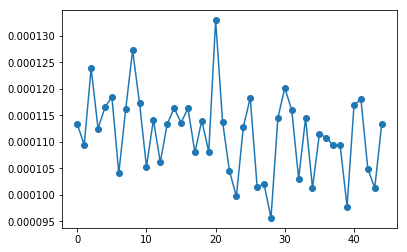

In [248]:
norm_plot(L1.norm_grad)

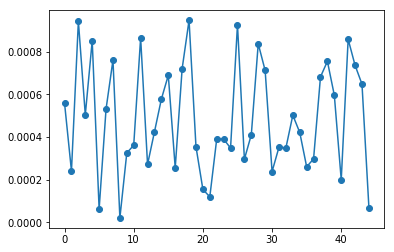

In [249]:
norm_plot(L2.norm_grad)

In [261]:
#6-scio warstwowa sieć
L1=Dense(784,20,viev_norm=1)
L2=Dense(20,10,viev_norm=1)
L3=Dense(10,8,viev_norm=1)
L4=Dense(8,7,viev_norm=1)
L5=Dense(7,2,viev_norm=1)
L6=Dense(2,1,viev_norm=1)
network = Network(loss=MSE(), optimizer=GD(0.01), metrics=[metric])
network.add(L1)
network.add(Sigmoid())
network.add(L2)
network.add(Sigmoid())
network.add(L3)
network.add(Sigmoid())
network.add(L4)
network.add(Sigmoid())
network.add(L5)
network.add(Sigmoid())
network.add(L6)
network.add(Sigmoid())
network.fit(X_train,y_train, epochs= 1, print_stats=True)

False
False
False
False
False
False
Epoch 1
    -> batch size: 256
    -> loss: 0.135121
    -> metric: 0.521916


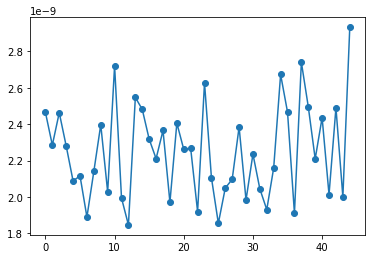

In [266]:
norm_plot(L1.norm_grad)

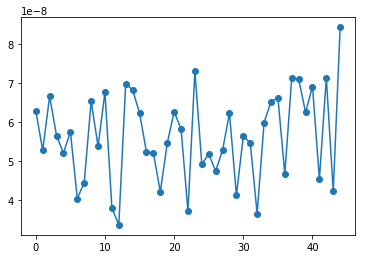

In [267]:
norm_plot(L2.norm_grad)

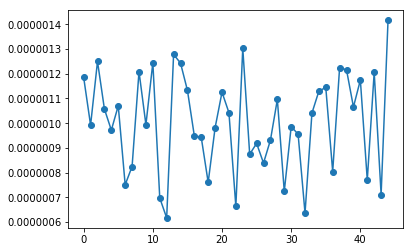

In [268]:
norm_plot(L3.norm_grad)

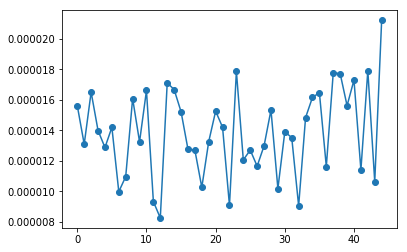

In [269]:
norm_plot(L4.norm_grad)

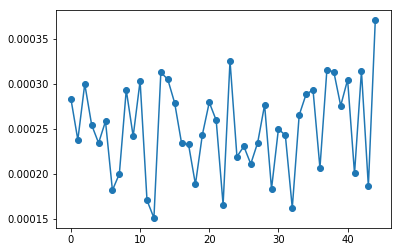

In [270]:
norm_plot(L5.norm_grad)

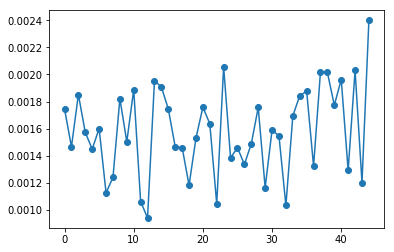

In [271]:
norm_plot(L6.norm_grad)

In [277]:
network = Network(loss=Crossentropy(), optimizer=Momentum(0.001,0.01), metrics=[metric])
network.add(Dense(784,5,init="stupid"))
network.add(ReLU())
network.add(Dense(5,1,init="stupid"))
network.add(Sigmoid())
network.fit(X_train,y_train, epochs= 10, print_stats=True)

False
False
Epoch 1
    -> batch size: 256
    -> loss: 4.780890
    -> metric: 0.521916
Epoch 2
    -> batch size: 256
    -> loss: 4.780890
    -> metric: 0.521916
Epoch 3
    -> batch size: 256
    -> loss: 4.780890
    -> metric: 0.521916
Epoch 4
    -> batch size: 256
    -> loss: 4.780890
    -> metric: 0.521916
Epoch 5
    -> batch size: 256
    -> loss: 4.780890
    -> metric: 0.521916
Epoch 6
    -> batch size: 256
    -> loss: 4.780890
    -> metric: 0.521916
Epoch 7
    -> batch size: 256
    -> loss: 4.780890
    -> metric: 0.521916
Epoch 8
    -> batch size: 256
    -> loss: 4.780890
    -> metric: 0.521916
Epoch 9
    -> batch size: 256
    -> loss: 4.780890
    -> metric: 0.521916
Epoch 10
    -> batch size: 256
    -> loss: 4.780890
    -> metric: 0.521916
